In [ ]:
import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
import random
import timeit
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from diffusers import DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from utils import CustomImageLabelDataset, mean_std, split_dataset, label_normalizer, freeze_layers, check_freeze_status
from unet import ConditionalUNet
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
RANDOM_SEED = 0
IMG_SIZE = 128
BATCH_SIZE = 16
TIME_EMBEDDING_DIM = 128
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
NUM_TIMESTEPS = 1000

max_power = 200.
min_power = 100.
max_scan_speed = 1.0
min_scan_speed = 0.5

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
image_folder = '/Users/xiezy/Documents/ml/diffusion/data/cross_sec/train_exp_2test/train/images'
label_folder = '/Users/xiezy/Documents/ml/diffusion/data/cross_sec/train_exp_2test/train/labels'

In [6]:
transform0 = transforms.Compose([
    transforms.Resize((128, 128),  # reshape to (128, 128), interpolation: nearest
                      interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor()  # rescale: from 0-255 to 0-1
])

dataset = CustomImageLabelDataset(image_folder=image_folder, label_folder=label_folder, transform=transform0)
mean, std = mean_std(dataset)

print(f'mean and std of the dataset are: {mean, std}')

mean and std of the dataset are: ([0.7159430384635925, 0.5838212966918945, 0.5889591574668884], [0.3238947093486786, 0.37139081954956055, 0.3363663852214813])


In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),  # normalize by the mean and std 
])

dataset = CustomImageLabelDataset(image_folder=image_folder_tune, label_folder=label_folder_tune, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'Dataloder is ready. There are {len(dataset)} images for training.')

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

NameError: name 'image_folder_tune' is not defined

In [10]:
model = ConditionalUNet()

freeze_layers(model.model)
check_freeze_status(model)

file_dir = '/bohr/rf-0767/v7'
file_name = 'simu_main_gau.pth'
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, file_name)

model.load_state_dict(torch.load(file_path, map_location=torch.device(device)))
model.to(device)
model.check_freeze_status()

Layer Name | requires_grad
------------------------------
condition_embedding.W                    Frozen
model.conv_in.weight                     Trainable
model.conv_in.bias                       Trainable
model.time_embedding.linear_1.weight     Trainable
model.time_embedding.linear_1.bias       Trainable
model.time_embedding.linear_2.weight     Trainable
model.time_embedding.linear_2.bias       Trainable
model.down_blocks.0.resnets.0.norm1.weight Frozen
model.down_blocks.0.resnets.0.norm1.bias Frozen
model.down_blocks.0.resnets.0.conv1.weight Frozen
model.down_blocks.0.resnets.0.conv1.bias Frozen
model.down_blocks.0.resnets.0.time_emb_proj.weight Frozen
model.down_blocks.0.resnets.0.time_emb_proj.bias Frozen
model.down_blocks.0.resnets.0.norm2.weight Frozen
model.down_blocks.0.resnets.0.norm2.bias Frozen
model.down_blocks.0.resnets.0.conv2.weight Frozen
model.down_blocks.0.resnets.0.conv2.bias Frozen
model.down_blocks.0.resnets.1.norm1.weight Frozen
model.down_blocks.0.resnets.1.no

OSError: [Errno 30] Read-only file system: '/bohr'

In [75]:
# Create a scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TIMESTEPS)

In [64]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)      #, weight_decay=WEIGHT_DECAY) 
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1 * LEARNING_RATE) # try

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader) * NUM_EPOCHS
)

losses = []

start = timeit.default_timer()
print(f'Everything is ready.\nTraining start time: {start:.2f}s')

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    
    for x, y in train_dataloader:
        clean_images = x.to(device)
        power, scan_speed = y[:, 0], y[:, 1]
        power = power.to(device)
        scan_speed = scan_speed.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        loss = 0
        for _ in range(GRADIENT_ACCUMULATION_STEPS):
            noisy_images_batch = noisy_images
            noise_pred = model(noisy_images_batch, timesteps, power, scan_speed)
            current_loss = F.mse_loss(noise_pred, noise)
            loss += current_loss / GRADIENT_ACCUMULATION_STEPS

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        lr_scheduler.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-100:])/100
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    
    print('-' * 50)

    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')
    print(f'Train Learning Rate EPOCH: {epoch + 1}: {train_learning_rate}')
    
    print('-' * 50)

end = timeit.default_timer()
print(f'Training finish time: {end:.2f}s')
print(f'Total training time: {end - start:.2f}s')

# save loss img and model parameters
save_dir = 'model'
os.makedirs(save_dir, exist_ok=True)

plt.figure()
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# model_name = '0210_model'

# cht_path = os.path.join(save_dir, f'{model_name}.png')
# plt.savefig(cht_path) 
# plt.close()
# print(f"Loss chart saved")

# mdl_path = os.path.join(save_dir, f'{model_name}.pth')
# torch.save(model.state_dict(), mdl_path)
# print('Model params saved')

Everything is ready.
Training start time: 707386.38s


  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

# EVA

In [372]:
model = ConditionalUNet()

file_dir = '/Users/xiezy/Documents/ml/diffusion/model_save'
file_name = 'c_dis2-2.pth'
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, file_name)

model.load_state_dict(torch.load(file_path, map_location=torch.device(device), weights_only=True))

model.eval()

model.to(device)

# Create a scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TIMESTEPS)

tensor([0.5000], device='mps:0') tensor([0.], device='mps:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9696118].


<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])
tensor([-0.0437,  0.0110, -0.0477])
tensor([0.5239, 0.4816, 0.4160])
tensor(0.9696)


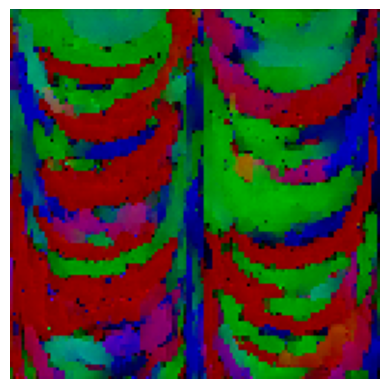

: 

In [ ]:
# generate random noise
# torch.manual_seed(0)
noise_scheduler.set_timesteps(num_inference_steps=30)

num_images = 1

x = torch.randn(num_images, 3, 128, 128).to(device)

power = torch.full((num_images, ), 150)
scan_speed = torch.full((num_images, ), 0.5)
# scan_speed = torch.tensor([0.75, 0.5, 0.25])
power = label_normalizer(power, max_power, min_power).to(device)
scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)
print(power, scan_speed)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

for i, t in enumerate(noise_scheduler.timesteps[-2:]):
    with torch.no_grad():
        residual = model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

x = x.detach().cpu()
print(type(x))
print(x.shape)
print(x.mean(dim=(0, 2, 3)))
print(x.std(dim=(0, 2, 3)))
print(torch.max(x))

grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

torch.Size([1, 3, 128, 128])
mean: tensor([0.7316, 0.5590, 0.6005])
std: tensor([0.1607, 0.1711, 0.1358])
max: 0.9735531210899353
min: 0.21243047714233398


(-0.5, 127.5, 127.5, -0.5)

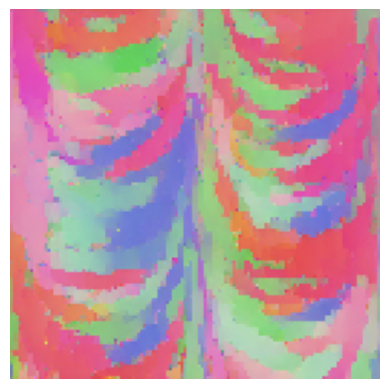

In [374]:
def img_denormalizer(batch, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)  
    denormalized_batch = batch * std + mean

    return denormalized_batch


denormalized_batch = img_denormalizer(x, mean, std)
print(denormalized_batch.shape)
print(f"mean: {denormalized_batch.mean(dim=(0, 2, 3))}\n"
      f"std: {denormalized_batch.std(dim=(0, 2, 3))}\n"
      f"max: {denormalized_batch.max()}\n"
      f"min: {denormalized_batch.min()}")

grid_img = torchvision.utils.make_grid(denormalized_batch)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

# plt.savefig('../data/cross_sec/gen_images/exp/exp_15.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
# plt.savefig('../data/long_sec/gen_images/fid/trans/trans_b.jpg', bbox_inches='tight', pad_inches=0, dpi=300)



# sample_img_1 = denormalized_batch.clamp(0, 1)
# sample_img_255 = (sample_img_1 * 255).byte().permute(0, 2, 3, 1)

# print(sample_img_255.shape)

# resize_transform = transforms.Resize((474, 474), interpolation=transforms.InterpolationMode.NEAREST)

# resized_imgs = []
# for i in range(sample_img_255.shape[0]):
#     pil_img = Image.fromarray(np.array(sample_img_255[i]))
#     resized_img = resize_transform(pil_img)
#     resized_imgs.append(resized_img)

# resized_imgs_np = np.array(resized_imgs)
# print(resized_imgs_np.shape)


# batch_size = resized_imgs_np.shape[0]
# ncols = 1
# nrows = (batch_size + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))

# if nrows == 1 or ncols == 1:
#     axes = np.array(axes).reshape(nrows, ncols)

# for i in range(batch_size):
#     ax = axes[i // ncols, i % ncols]
#     ax.imshow(resized_imgs_np[i])
#     ax.axis('off')

# for j in range(batch_size, nrows * ncols):
#     axes[j // ncols, j % ncols].axis('off')

# plt.tight_layout()
# plt.show()